In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor,transforms,v2
from pathlib import Path
from PIL import Image
from torch import nn
import torch
import random
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torchinfo import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def accuracy_fn(y_pred, y_true):
    correct_num = (y_pred == y_true).sum()
    acc = correct_num / len(y_true) * 100
    return acc

In [4]:
def train_step(dataloader, model, cost_fn, optimizer, accuracy_fn, device):
    train_cost = 0
    train_acc = 0
    for batch, (x, y) in enumerate(dataloader):

        x = x.to(device)
        y = y.to(device)
        
        model.train()
        y_pred =  model(x)
        cost = cost_fn(y_pred,y)
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

        train_cost += cost

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    train_cost /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_cost, train_acc
    
def test_step(dataloader, model, cost_fn, accuracy_fn, device):
    test_cost = 0
    test_acc = 0
    model.eval()
    with torch.inference_mode():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            test_pred =  model(x)
            
            test_cost += cost_fn(test_pred,y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

        test_cost /= len(dataloader)
        test_acc /= len(dataloader)

        return test_cost, test_acc

## Model

In [5]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model = torchvision.models.efficientnet_b1(weights = weights)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
weights.transforms()

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
efficientnet_b1_transforms = weights.transforms()

In [8]:
train_dataset = datasets.CIFAR10(
    root = "image",
    train = True,
    download = True,
    transform = efficientnet_b1_transforms
)

test_dataset = datasets.CIFAR10(
    root = "image",
    train = False,
    download = True,
    transform = efficientnet_b1_transforms
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader = DataLoader(test_dataset,batch_size = BATCH_SIZE,shuffle = False)

In [10]:
len(train_dataloader)

1563

In [11]:
summary(model=model,
       input_size=(32, 3, 128, 128),
       col_names=["input_size","output_size","num_params","trainable"],
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 128, 128]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 128, 128]         [32, 1280, 4, 4]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 128, 128]         [32, 32, 64, 64]          --                        True
│    │    └─Conv2d (0)                                       [32, 3, 128, 128]         [32, 32, 64, 64]          864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 64, 64]          [32, 32, 64, 64]          64                        True
│    │    └─SiLU (2)                                         [32, 32, 64, 64]          [32, 32, 64, 64]          --                

In [12]:
# This is transfer learning (feature extraction mode):

# Freeze backbone (remain the pretrained features)

# Train only the final classifier to map features → the labels

In [13]:
model.classifier[1] = nn.Linear(in_features=1280,out_features=10,bias=True).to(device)

In [14]:
for param in model.features.parameters():
    param.requires_grad=False
    # print(param)

In [15]:
from torch.optim.lr_scheduler import StepLR

cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [16]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch} \n -----")

    train_cost, train_acc = train_step(train_dataloader, model, cost_fn, optimizer, accuracy_fn, device)

    test_cost, test_acc = test_step(test_dataloader, model, cost_fn, accuracy_fn, device)

    scheduler.step()

    train_losses.append(train_cost.detach().cpu().item())
    test_losses.append(test_cost.detach().cpu().item())
    train_accuracies.append(train_acc.detach().cpu().item())
    test_accuracies.append(test_acc.detach().cpu().item())

    print(f"\nTrain Cost: {train_cost:.4f}, {train_acc:.2f}")

    print(f"Test Cost: {test_cost:.4f}, {test_acc:.2f} \n")

Epoch: 0 
 -----

Train Cost: 0.7885, 72.88
Test Cost: 0.6055, 79.57 

Epoch: 1 
 -----

Train Cost: 0.7516, 74.62
Test Cost: 0.5754, 80.43 

Epoch: 2 
 -----

Train Cost: 0.7471, 74.76
Test Cost: 0.5979, 79.51 

Epoch: 3 
 -----

Train Cost: 0.7477, 74.67
Test Cost: 0.5694, 80.54 

Epoch: 4 
 -----

Train Cost: 0.7473, 74.71
Test Cost: 0.5856, 79.88 

Epoch: 5 
 -----

Train Cost: 0.6918, 76.12
Test Cost: 0.5443, 81.19 

Epoch: 6 
 -----

Train Cost: 0.6779, 76.67
Test Cost: 0.5303, 81.83 

Epoch: 7 
 -----

Train Cost: 0.6760, 76.65
Test Cost: 0.5278, 81.66 

Epoch: 8 
 -----

Train Cost: 0.6716, 76.79
Test Cost: 0.5345, 81.70 

Epoch: 9 
 -----

Train Cost: 0.6718, 76.54
Test Cost: 0.5324, 81.78 



In [17]:
# Retraining the last layer is not enough

# Because the model needs to:

# Adapt deeper features

# Ignore irrelevant ImageNet patterns (dog fur, cat eyes, textures, etc.)

In [18]:
for param in model.features[-2:].parameters():
    param.requires_grad = True

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [20]:
print("\nPhase 2: Fine-tuning the backbone")

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch} \n -----")

    train_cost, train_acc = train_step(train_dataloader, model, cost_fn, optimizer, accuracy_fn, device)

    test_cost, test_acc = test_step(test_dataloader, model, cost_fn, accuracy_fn, device)

    scheduler.step()

    train_losses.append(train_cost.detach().cpu().item())
    test_losses.append(test_cost.detach().cpu().item())
    train_accuracies.append(train_acc.detach().cpu().item())
    test_accuracies.append(test_acc.detach().cpu().item())

    print(f"\nTrain Cost: {train_cost:.4f}, {train_acc:.2f}")

    print(f"Test Cost: {test_cost:.4f}, {test_acc:.2f} \n")


Phase 2: Fine-tuning the backbone
Epoch: 0 
 -----

Train Cost: 0.6126, 78.72
Test Cost: 0.4811, 83.61 

Epoch: 1 
 -----

Train Cost: 0.5616, 80.41
Test Cost: 0.4561, 84.44 

Epoch: 2 
 -----

Train Cost: 0.5321, 81.31
Test Cost: 0.4534, 84.72 

Epoch: 3 
 -----

Train Cost: 0.5153, 81.93
Test Cost: 0.4266, 85.50 

Epoch: 4 
 -----

Train Cost: 0.4986, 82.40
Test Cost: 0.4162, 85.88 

Epoch: 5 
 -----

Train Cost: 0.4817, 83.04
Test Cost: 0.4105, 86.09 

Epoch: 6 
 -----

Train Cost: 0.4637, 83.86
Test Cost: 0.4019, 86.45 

Epoch: 7 
 -----

Train Cost: 0.4521, 84.11
Test Cost: 0.3990, 86.45 

Epoch: 8 
 -----

Train Cost: 0.4387, 84.58
Test Cost: 0.3862, 87.01 

Epoch: 9 
 -----

Train Cost: 0.4241, 85.10
Test Cost: 0.3819, 87.00 



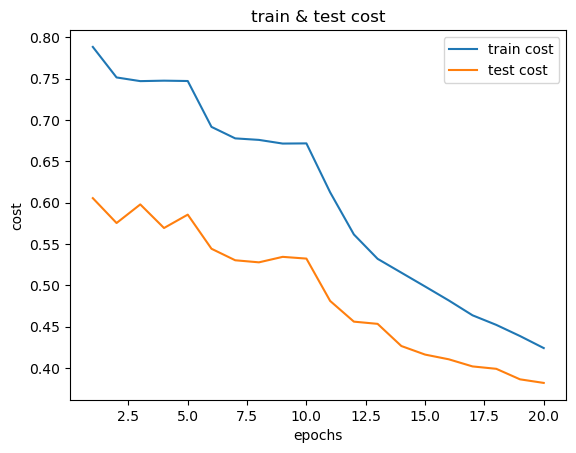

In [21]:
plt.plot(range(1,len(train_losses) + 1), train_losses, label = "train cost")
plt.plot(range(1,len(test_losses) + 1), test_losses, label = "test cost")
plt.title("train & test cost")
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend()
plt.show()

## save model

In [25]:
# torch.save(model.state_dict(), "efficientnet_cifar10.pth")